In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


# Generate dataset

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


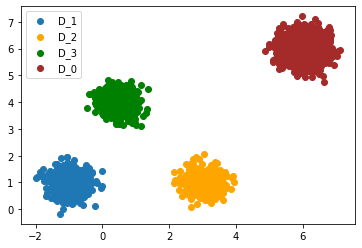

In [10]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)
x = np.zeros((5000,2))
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [-1,1],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [3,1],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [0.5,4],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))
color = ['#1F77B4','orange', 'g','brown']
name = [1,2,3,0]
for i in range(10):
  if i==3:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3],label="D_"+str(name[i]))
  elif i>=4:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[i],label="D_"+str(name[i]))
plt.legend()

Text(0, 0.5, 'X2')

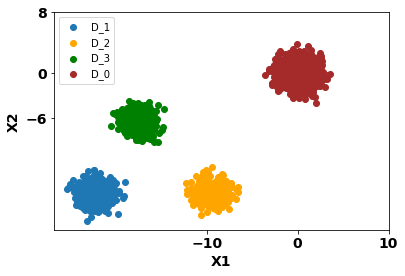

In [12]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)
color = ['#1F77B4','orange', 'g','brown']
for i in range(10):
  if i==3:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3],label="D_"+str(name[i]))
  elif i>=4:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[i],label="D_"+str(name[i]))
plt.legend()
plt.xticks([-10, 0, 10], fontsize=14, fontweight = 'bold')
plt.yticks([-6, 0, 8], fontsize=14, fontweight = 'bold')
plt.xlabel("X1", fontsize=14, fontweight = 'bold')
plt.ylabel("X2" , fontsize=14, fontweight = 'bold')
# plt.savefig(fp_cin+"ds2_data.png", bbox_inches="tight")
# plt.savefig(fp_cin+"ds2_data.pdf", bbox_inches="tight")

In [13]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [17]:
desired_num = 2000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = 0
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(18,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [18]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T
mosaic_list_of_images[0]

array([-2.12794835e+01, -1.70827549e+01, -1.07177876e-01, -9.40161908e-01,
        9.46851025e-01, -1.08338312e-01,  9.93009448e-01, -1.13787054e+00,
        1.94337545e-02, -5.89946440e-02,  6.59178562e-01,  3.91575569e-01,
        1.72459719e-01, -7.36957052e-01,  1.41670137e-01, -7.90224414e-01,
       -6.38808433e-01, -1.14528944e-01])

In [19]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((2000, 18),
 array([-2.12794835e+01, -1.70827549e+01, -1.07177876e-01, -9.40161908e-01,
         9.46851025e-01, -1.08338312e-01,  9.93009448e-01, -1.13787054e+00,
         1.94337545e-02, -5.89946440e-02,  6.59178562e-01,  3.91575569e-01,
         1.72459719e-01, -7.36957052e-01,  1.41670137e-01, -7.90224414e-01,
        -6.38808433e-01, -1.14528944e-01]))

In [21]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [22]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000] , fore_idx[0:1000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [23]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[1000:2000], mosaic_label[1000:2000] , fore_idx[1000:2000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [58]:
class Focus(nn.Module):
  def __init__(self):
      super(Focus,self).__init__()
      self.fc1 = nn.Linear(2,1)

  def forward(self,z):
      x = torch.zeros([batch,9],dtype=torch.float64)
      y = torch.zeros([batch,2], dtype=torch.float64)
      x,y = x.to("cuda"),y.to("cuda")
      for i in range(9):
          x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
          #print(k[:,0].shape,x[:,i].shape)
      x = F.softmax(x,dim=1)   # alphas
      x1 = x[:,0]
      for i in range(9):
          x1 = x[:,i]          
          #print()
          y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
      # print(y.shape, x.shape)
      return x , y
    
  def helper(self, x):
    x = x.view(-1, 2)
    # x = F.relu(self.fc1(x))
    x = (self.fc1(x))

    return x

In [59]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 3)


  def forward(self, x):
    x = x.view(-1, 2)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [92]:
import torch.optim as optim

def train(train_loader, test_loader, focus_net, classify):    
  criterion = nn.CrossEntropyLoss()
  optimizer_classify = optim.Adam(classify.parameters(), lr=0.01 ) #, momentum=0.9)
  optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01 ) #, momentum=0.9)

  print('-'*50)
  print(focus_net.fc1.weight, classify.fc1.weight, classify.fc1.bias)
  nos_epochs = 1000
  loss_ret=0.0
  for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    epoch_loss = []
    cnt=0

    iteration = desired_num // batch
    
    #training data set
    
    for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
      inputs = inputs.double()
      labels = labels
      # zero the parameter gradients
      
      optimizer_focus.zero_grad()
      optimizer_classify.zero_grad()
      
      alphas, avg_images = focus_net(inputs)
      outputs = classify(avg_images)

      _,predicted = torch.max(outputs.data, 1)
      # print(predicted)
      # print(outputs.shape,labels.shape)
      # print(outputs)
      # print(labels)
      loss = criterion(outputs, labels) 
      loss.backward()
      optimizer_focus.step()
      optimizer_classify.step()

      running_loss += loss.item()
      # mini = 3
      # if cnt % mini == mini-1 :    # print every 40 mini-batches
      epoch_loss.append(running_loss)
      running_loss = 0.0
      cnt=cnt+1
    loss_ret = np.mean(epoch_loss)
    if(epoch%200==0):
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, np.mean(epoch_loss)))
    if(np.mean(epoch_loss) <= 0.001):
        break;

  with torch.no_grad():
    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0
    for data in test_loader:
      inputs, labels , fore_idx = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
      alphas, avg_images = focus_net(inputs)
      outputs = classify(avg_images)
      _,predicted = torch.max(outputs.data, 1)

      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        # print(focus, fore_idx[j], predicted[j], labels[j])
        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  print('Finished Training')  
  return loss_ret, argmax_more_than_half/10, focus_true_pred_true/10, focus_false_pred_true/10, focus_true_pred_false/10 , focus_false_pred_false/10, focus_net.fc1.weight, classify.fc1.weight, classify.fc1.bias
    


In [116]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[0.0, 0.0]])))
torch.manual_seed(12)
classify = Classification().double()
classify.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0] ])))
classify.fc1.bias = torch.nn.Parameter(torch.tensor(np.array([0.0, 0.0, 0.0])))
focus_net = focus_net.to("cuda")
classify = classify.to("cuda")
# print("--"*40,"a,b,c = ",a[i],b[j],c[k])
print(focus_net.fc1.weight, classify.fc1.weight, classify.fc1.bias)

Parameter containing:
tensor([[0., 0.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([0., 0., 0.], device='cuda:0', dtype=torch.float64, requires_grad=True)


In [117]:
cost, alpha_per, ftpt, ffpt, ftpf, ffpf, f_a, f_b, f_c = train(train_loader, test_loader, focus_net, classify)

--------------------------------------------------
Parameter containing:
tensor([[0., 0.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([0., 0., 0.], device='cuda:0', dtype=torch.float64, requires_grad=True)
[1,     5] loss: 1.081
[201,     5] loss: 0.010
[401,     5] loss: 0.005
[601,     5] loss: 0.003
[801,     5] loss: 0.002
Finished Training


In [114]:
def tensor_to_list1d(var):
  r = var.shape[0]
  res = []
  for i in range(r):
    res.append(np.round(var[i].item(),3))
  return res

In [119]:
def tensor_to_list2d(var):
  r = var.shape[0]
  c = var.shape[1]
  res = []
  for i in range(r):
    temp=[]
    for j in range(c):
      temp.append(np.round(var[i][j].item(),3))
    res.append(temp)
  return res

In [108]:
f_a[0][0].item(), f_a[0][1].item(), f_a, f_a.shape[0]

(-0.05899574000165298, -0.23169413344374595, Parameter containing:
 tensor([[-0.0590, -0.2317]], device='cuda:0', dtype=torch.float64,
        requires_grad=True), 1)

In [112]:
f_c.shape

torch.Size([3])

In [120]:
tensor_to_list2d(f_a)

[[-0.052, -0.221]]

In [115]:
tensor_to_list1d(f_c)

[-3.488, 1.78, 4.611]

In [121]:
a = [-0.1, 0.0, 0.1]
b = [-0.1, 0.0, 0.1]
c = [-0.1, 0.0, 0.1]

In [122]:
all_loss=[]
all_alphas_more_than_half=[]
all_ftpt=[]
all_ffpt=[]
all_ftpf = []
all_ffpf= []
init_a = []
init_b = []
init_c = []
final_a=[]
final_b = []
final_c = []

for i in range(3):
  for j in range(3):
    for k in range(3):
      torch.manual_seed(12)
      focus_net = Focus().double()
      focus_net.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[a[i], b[j]]])))
      torch.manual_seed(12)
      classify = Classification().double()
      classify.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[a[i], b[j]],[a[i], b[j]],[a[i], b[j]]])))
      classify.fc1.bias = torch.nn.Parameter(torch.tensor(np.array([a[i], b[j], c[k]])))
      focus_net = focus_net.to("cuda")
      classify = classify.to("cuda")
      print("--"*40,"a,b,c = ",a[i],b[j],c[k])
      cost, alpha_per, ftpt, ffpt, ftpf, ffpf, f_a, f_b, f_c = train(train_loader, test_loader, focus_net, classify)
      print(cost, alpha_per, ftpt, ffpt, ftpf, ffpf)
      init_a.append([a[i], b[j]])
      init_b.append([[a[i], b[j]],[a[i], b[j]],[a[i], b[j]]])
      init_c.append([a[i], b[j], c[k]])
      final_a.append(tensor_to_list2d(f_a))
      final_b.append(tensor_to_list2d(f_b))
      final_c.append(tensor_to_list1d(f_c))
      all_loss.append(np.round(cost,3))
      all_alphas_more_than_half.append(alpha_per)
      all_ftpt.append(ftpt)
      all_ffpt.append(ffpt)
      all_ftpf.append(ftpf)
      all_ffpf.append(ffpf)



-------------------------------------------------------------------------------- a,b,c =  -0.1 -0.1 -0.1
--------------------------------------------------
Parameter containing:
tensor([[-0.1000, -0.1000]], device='cuda:0', dtype=torch.float64,
       requires_grad=True) Parameter containing:
tensor([[-0.1000, -0.1000],
        [-0.1000, -0.1000],
        [-0.1000, -0.1000]], device='cuda:0', dtype=torch.float64,
       requires_grad=True) Parameter containing:
tensor([-0.1000, -0.1000, -0.1000], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
[1,     5] loss: 1.031
[201,     5] loss: 0.010
[401,     5] loss: 0.005
[601,     5] loss: 0.003
[801,     5] loss: 0.002
Finished Training
0.000994904100129965 95.3 100.0 0.0 0.0 0.0
-------------------------------------------------------------------------------- a,b,c =  -0.1 -0.1 0.0
--------------------------------------------------
Parameter containing:
tensor([[-0.1000, -0.1000]], device='cuda:0', dtype=torch.float64,
    

In [123]:
# df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [124]:
columns = ["init_a", "init_b", "init_c", "final_a", "final_b", "final_c", "train_loss", "argmax > 0.5" , "ftpt", "ffpt", "ftpf", "ffpf" ]

In [125]:
df_test[columns[0]] = init_a
df_test[columns[1]] = init_b
df_test[columns[2]] = init_c
df_test[columns[3]] = final_a
df_test[columns[4]] = final_b
df_test[columns[5]] = final_c
df_test[columns[6]] = all_loss
df_test[columns[7]] = all_alphas_more_than_half
df_test[columns[8]] = all_ftpt
df_test[columns[9]] = all_ffpt
df_test[columns[10]] = all_ftpf
df_test[columns[11]] = all_ffpf

In [126]:
df_test

,init_a,init_b,init_c,final_a,final_b,final_c,train_loss,argmax > 0.5,ftpt,ffpt,ftpf,ffpf
0,"[-0.1, -0.1]","[[-0.1, -0.1], [-0.1, -0.1], [-0.1, -0.1]]","[-0.1, -0.1, -0.1]","[[-0.056, -0.22]]","[[-0.264, -0.707], [1.475, -2.01], [-1.361, 2....","[-3.931, 2.447, 4.165]",0.001,95.3,100.0,0.0,0.0,0.0
1,"[-0.1, -0.1]","[[-0.1, -0.1], [-0.1, -0.1], [-0.1, -0.1]]","[-0.1, -0.1, 0.0]","[[-0.052, -0.225]]","[[-0.251, -0.702], [1.489, -2.008], [-1.332, 2...","[-3.921, 2.419, 4.233]",0.001,94.7,100.0,0.0,0.0,0.0
2,"[-0.1, -0.1]","[[-0.1, -0.1], [-0.1, -0.1], [-0.1, -0.1]]","[-0.1, -0.1, 0.1]","[[-0.049, -0.23]]","[[-0.236, -0.694], [1.505, -2.005], [-1.3, 2.0...","[-3.913, 2.381, 4.292]",0.001,93.2,100.0,0.0,0.0,0.0
3,"[-0.1, 0.0]","[[-0.1, 0.0], [-0.1, 0.0], [-0.1, 0.0]]","[-0.1, 0.0, -0.1]","[[-0.161, -0.089]]","[[-0.293, -0.508], [1.444, -1.962], [-1.391, 2...","[-3.175, 1.199, 5.804]",0.001,100.0,100.0,0.0,0.0,0.0
4,"[-0.1, 0.0]","[[-0.1, 0.0], [-0.1, 0.0], [-0.1, 0.0]]","[-0.1, 0.0, 0.0]","[[-0.093, -0.167]]","[[-0.276, -0.497], [1.448, -1.932], [-1.346, 2...","[-3.109, 1.228, 5.458]",0.001,100.0,100.0,0.0,0.0,0.0
5,"[-0.1, 0.0]","[[-0.1, 0.0], [-0.1, 0.0], [-0.1, 0.0]]","[-0.1, 0.0, 0.1]","[[-0.038, -0.244]]","[[-0.269, -0.473], [1.463, -1.911], [-1.314, 2...","[-3.112, 1.284, 5.237]",0.001,87.3,100.0,0.0,0.0,0.0
6,"[-0.1, 0.1]","[[-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1]]","[-0.1, 0.1, -0.1]","[[-0.53, -0.13]]","[[-0.132, -0.588], [1.682, -2.148], [-1.418, 2...","[-2.855, 1.184, 5.524]",0.001,100.0,100.0,0.0,0.0,0.0
7,"[-0.1, 0.1]","[[-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1]]","[-0.1, 0.1, 0.0]","[[-0.516, -0.137]]","[[-0.139, -0.544], [1.671, -2.103], [-1.402, 2...","[-2.836, 1.157, 5.746]",0.001,100.0,100.0,0.0,0.0,0.0
8,"[-0.1, 0.1]","[[-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1]]","[-0.1, 0.1, 0.1]","[[-0.503, -0.144]]","[[-0.144, -0.514], [1.665, -2.073], [-1.398, 2...","[-2.822, 1.14, 5.804]",0.001,100.0,100.0,0.0,0.0,0.0
9,"[0.0, -0.1]","[[0.0, -0.1], [0.0, -0.1], [0.0, -0.1]]","[0.0, -0.1, -0.1]","[[-0.088, -0.169]]","[[-0.038, -0.69], [1.744, -2.022], [-1.31, 2.3...","[-3.762, 2.708, 3.528]",0.001,99.9,100.0,0.0,0.0,0.0


In [127]:
df_test.to_csv("linear_linear_simultaneous.csv")